In [ ]:
#| eval: false
! [ -e /content ] && pip install -Uqq xcube # upgrade xcube on colab

In [ ]:
from xcube.l2r.all import *

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

Make sure we have that "beast":

In [ ]:
ic(torch.cuda.get_device_name(default_device()));
test_eq(torch.cuda.get_device_name(0), torch.cuda.get_device_name(default_device()))
test_eq(default_device(), torch.device(0))
print(f"GPU memory = {torch.cuda.get_device_properties(default_device()).total_memory/1024**3}GB")

ic| torch.cuda.get_device_name(default_device()): 'NVIDIA GeForce RTX 3060 Laptop GPU'


GPU memory = 5.99951171875GB


Setting some environment variables:

In [ ]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Setting defaults for pandas and matplotlib:

In [ ]:
# Set the default figure size
plt.rcParams["figure.figsize"] = (12, 6)

# L2R Training

> Training a learning-to-rank model

In this tutorial we will train a l2r model. We will bootstrap the model using the data we prepared in tutorial [booting L2R](14_tutorial.boot_l2r.ipynb)

## Getting ready

Prepping l2r data for xcube's `L2RDataLoader`

In [ ]:
source = untar_xxx(XURLs.MIMIC3_L2R)
source.ls()

(#11) [Path('/home/deb/.xcube/data/mimic3_l2r/info.pkl'),Path('/home/deb/.xcube/data/mimic3_l2r/code_descriptions.csv'),Path('/home/deb/.xcube/data/mimic3_l2r/mimic3-9k_tok_lbl_info.pkl'),Path('/home/deb/.xcube/data/mimic3_l2r/code_desc.pkl'),Path('/home/deb/.xcube/data/mimic3_l2r/p_TL.pkl'),Path('/home/deb/.xcube/data/mimic3_l2r/trn_val_split.pkl'),Path('/home/deb/.xcube/data/mimic3_l2r/mimic3-9k_tok.ft'),Path('/home/deb/.xcube/data/mimic3_l2r/mimic3-9k_lbl.ft'),Path('/home/deb/.xcube/data/mimic3_l2r/mimic3-9k.csv'),Path('/home/deb/.xcube/data/mimic3_l2r/scored_tokens.pth')...]

Note: If you don't have enough GPU/CPU memory just run the last cell of this section to load the pregenerated ones.

Here we can just load the file which contains the relevant information about the tokens, labels and their mutual-information-gain:

In [ ]:
# Cheking if you have enough memory to set device
cuda_memory = torch.cuda.get_device_properties(torch.cuda.current_device()).total_memory/1024**3
if cuda_memory < 10.: print(f"Not Enough GPU Memory (just {cuda_memory} GB), we'll use {default_device(use=False)}")
l2r_bootstrap = torch.load(source/'mimic3-9k_tok_lbl_info.pkl', map_location=default_device())

Not Enough GPU Memory (just 5.99951171875 GB), we'll use cpu


In [ ]:
test_eq(l2r_bootstrap.keys(), ['toks', 'lbs', 'mut_info_lbl_entropy', 'mutual_info_jaccard'])
toks = l2r_bootstrap.get('toks', None)
lbs = l2r_bootstrap.get('lbs', None)
info = l2r_bootstrap.get('mutual_info_jaccard', None)
for o in (toks, lbs, info): assert o is not None
test_eq(info.shape, (len(toks), len(lbs)))

`info` contains the mutual-information-gain values for the tokens and labels. In what follows we'll toss in some pandas to take a good hard look at the data before we proceed towards making xcube's `L2RDataLoader`: 

*Note:* Storing the tokens and the labels in a dataframe as `object` will take up a lot of RAM space when we prepare that `DataLoader`. So we are going to store the corresponding token and label indices instead in a dataframe called `df_l2r`. We are also going to store the tokens and the labels with their corresponding indices in seperate dataframes (this will help in quick merging for analysis).

Here we will rank the tokens for each label based on the decreasing values of the mutual-info and stack them up with mutual-info.

In [ ]:
ranked = info.argsort(descending=True, dim=0).argsort(dim=0)
info_ranked =torch.stack((info, ranked), dim=2).flatten(start_dim=1)

In [ ]:
cols = pd.MultiIndex.from_product([range(len(lbs)), ['mutual_info', 'rank']], names=['label', 'key2'])
df_l2r = pd.DataFrame(info_ranked, index=range(len(toks)), columns=cols)
df_l2r.index.name='token'

In [ ]:
df_l2r.head(3)

label        0                    1                    2              \
key2  mutual_info     rank mutual_info     rank mutual_info     rank   
token                                                                  
0        0.000022    866.0    0.000011   1022.0    0.000022   1156.0   
1        0.000000  56856.0    0.000000  41420.0    0.000000  56855.0   
2        0.000000  56857.0    0.000000  41427.0    0.000000  56856.0   

label        3                    4              ...        8917           \
key2  mutual_info     rank mutual_info     rank  ... mutual_info     rank   
token                                            ...                        
0        0.000011    823.0    0.000033    984.0  ...    0.000011    850.0   
1        0.000000  41412.0    0.000000  22838.0  ...    0.000000  41423.0   
2        0.000000  41413.0    0.000000  22843.0  ...    0.000000  41430.0   

label        8918                 8919                 8920           \
key2  mutual_info     rank mutual_info     rank mutual_info     rank   
token                                                                  
0        0.000033    944.0    0.000011    960.0    0.000011    771.0   
1        0.000000  22863.0    0.000000  41425.0    0.000000  41414.0   
2        0.000000  22870.0    0.000000  41432.0    0.000000  41421.0   

label          8921           
key2    mutual_info     rank  
token                         
0      6.888287e-07  31821.0  
1      0.000000e+00  32387.0  
2      0.000000e+00  32390.0  

[3 rows x 17844 columns]

In [ ]:
df_l2r = df_l2r.stack(level=0).reset_index().rename_axis(None, axis=1)
# the above pandas trick can be simulated using numpy as follows
# n = df_l2r.to_numpy()
# n_toks, n_lbs = len(df_l2r.index), len(df_l2r.columns.levels[0])
# n = n.reshape(-1, 2)
# tok_lbs_idxs = np.mgrid[slice(0,n_toks), slice(0,n_lbs)].reshape(2,-1).T
# n = np.concatenate((tok_lbs_idxs,n), axis=-1)
# df_l2r = pd.DataFrame(n, columns=['token', 'label', 'mutual_info', 'rank'])
df_l2r[['token', 'label']] = df_l2r[['token', 'label']].astype(np.int32) 
test_eq(len(df_l2r), len(toks) * len(lbs))

In [ ]:
df_l2r.head(3)

,token,label,mutual_info,rank
0,0,0,0.000022,866.0
1,0,1,0.000011,1022.0
2,0,2,0.000022,1156.0


In [ ]:
df_l2r.memory_usage()/1024**3

Index          1.192093e-07
token          1.906211e+00
label          1.906211e+00
mutual_info    1.906211e+00
rank           1.906211e+00
dtype: float64

In [ ]:
df_toks = pd.DataFrame([(i, w) for i,w in enumerate(toks)], columns=['token', 'tok_val'])
df_lbs = pd.DataFrame([(i,w) for i, w in enumerate(lbs)], columns=['lbl', 'lbl_val'])

In [ ]:
df_toks.head(3)

,token,tok_val
0,0,xxunk
1,1,xxpad
2,2,xxbos


In [ ]:
df_lbs.head(3)

,lbl,lbl_val
0,0,003.0
1,1,003.1
2,2,003.8


You can save `df_l2r`, `df_toks` and `df_lbs` if you are working on your own dataset. In this case though `untar_xxx` has already downloaded those for you.

In [ ]:
L(source.glob("**/*.ft"))

(#3) [Path('/home/deb/.xcube/data/mimic3_l2r/mimic3-9k_tok.ft'),Path('/home/deb/.xcube/data/mimic3_l2r/mimic3-9k_lbl.ft'),Path('/home/deb/.xcube/data/mimic3_l2r/mimic3-9k_tok_lbl.ft')]

## Statistical Analysis

In [ ]:
#| eval: false
df_l2r = pd.read_feather(source/'mimic3-9k_tok_lbl.ft')
test_eq(df_l2r.dtypes.mutual_info, np.float32)

In [ ]:
df_l2r.head(3)

,token,label,mutual_info,rank,bcx_mutual_info
0,0,0,0.000022,866.0,-6.530356
1,0,1,0.000011,1022.0,-6.753679
2,0,2,0.000022,1156.0,-6.530356


If you loaded the pregenerated `df_l2r` then you will see the column "bcx_mutual_info". It is a box-cox transformation of the "mutual-info". In this section we'll justify that transformation. So let's perform some statistical analysis of that `mutual_info` column before we build the `L2RDataLoader` in the next section.

In [ ]:
# import gc; gc.collect()
# df_l2r.info()
# ic(df_l2r.memory_usage().sum()/1024**3)
# ic(sys.getsizeof(df_l2r)/1024**3);
# df_collab.token.nunique()

In [ ]:
mut_infos = df_l2r['mutual_info'].to_numpy()

In [ ]:
mut_infos.min(), mut_infos.max(), mut_infos.mean()

(-6.852321e-05, 0.99999636, 7.175153e-05)

In [ ]:
%%time
skew(mut_infos)

CPU times: user 2.31 s, sys: 940 ms, total: 3.25 s
Wall time: 3.25 s


142.75660007849734

The mutual-info values are incredibly skewed. So we need to apply some transformation. Sometimes `mut_infos` might contain negs, we need to convert those to eps.

In [ ]:
# np.where(mut_infos<0, 1, 0).sum() # or, better yet
where_negs = mut_infos < 0
ic(np.sum(where_negs))
eps = np.float32(1e-20)
mut_infos[where_negs] = eps
test_eq(np.sum(mut_infos<0), 0)
ic(np.min(mut_infos), np.max(mut_infos), np.mean(mut_infos));

ic| np.sum(where_negs): 111226814
ic| np.min(mut_infos): 0.0
    np.max(mut_infos): 0.99999636
    np.mean(mut_infos): 7.697003e-05


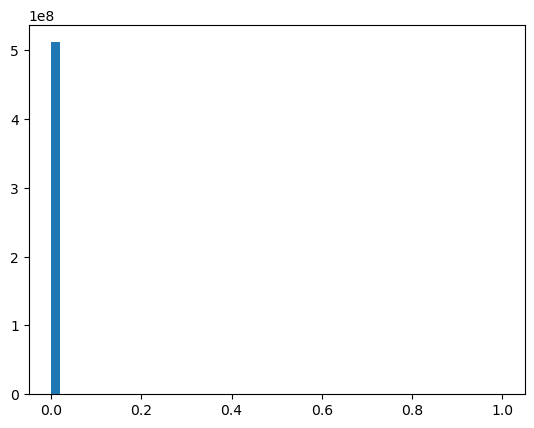

In [ ]:
hist, bins, _ = plt.hist(mut_infos, bins=50)
# plt.yscale('log')

**Applying log transform:**

In [ ]:
log_mut_infos = np.log(mut_infos + eps)

In [ ]:
np.isnan(log_mut_infos).sum(), np.isneginf(log_mut_infos).sum(), np.isinf(log_mut_infos).sum()

(0, 0, 0)

In [ ]:
%time skew(log_mut_infos)

CPU times: user 2.37 s, sys: 900 ms, total: 3.27 s
Wall time: 3.27 s


-1.3383214188674972

A little better skewness than before!

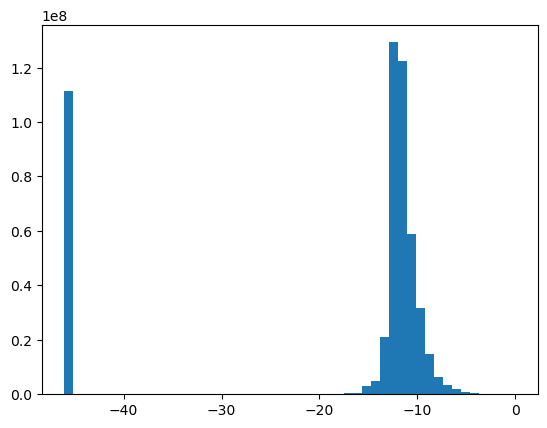

In [ ]:
hist, bins, _ = plt.hist(log_mut_infos, bins=50,)

**Applying sqrt transform:**

In [ ]:
sqrt_mut_infos = np.sqrt(mut_infos)

In [ ]:
np.isnan(sqrt_mut_infos).sum(), np.isinf(sqrt_mut_infos).sum(), np.isneginf(sqrt_mut_infos).sum()

(0, 0, 0)

In [ ]:
%time skew(sqrt_mut_infos)

CPU times: user 2.28 s, sys: 1.19 s, total: 3.47 s
Wall time: 3.47 s


16.40865608826817

Worse than log transform!

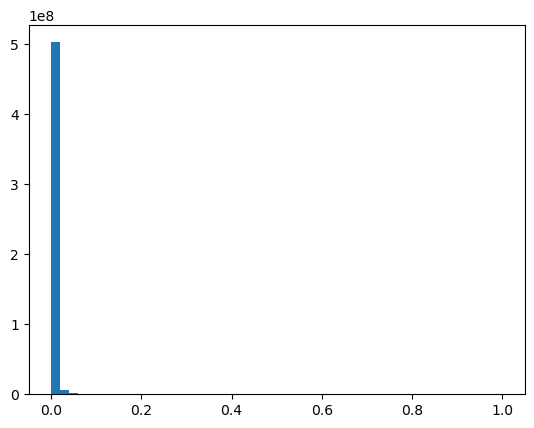

In [ ]:
hist, bins, _ = plt.hist(sqrt_mut_infos, bins=50)

**Apply box-cox transfrom:**

In [ ]:
bcx_mut_infos, *_ = boxcox(mut_infos+eps)

/home/deb/miniconda3/envs/deep/lib/python3.10/site-packages/scipy/stats/_morestats.py:933: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/home/deb/miniconda3/envs/deep/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [ ]:
np.isnan(bcx_mut_infos).sum(), np.isinf(bcx_mut_infos).sum(), np.isneginf(bcx_mut_infos).sum()

(0, 0, 0)

In [ ]:
%time skew(bcx_mut_infos)

CPU times: user 2.43 s, sys: 830 ms, total: 3.26 s
Wall time: 3.26 s


-0.885981418331696

This is the best skew so we'll go with boxcox.

In [ ]:
df_l2r['bcx_mutual_info'] = bcx_mut_infos

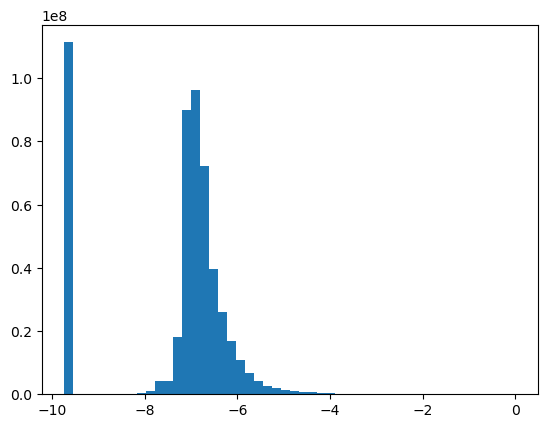

In [ ]:
#| eval: false
hist, bins, _ = plt.hist(bcx_mut_infos, bins=50)

In [ ]:
#| eval: false
np.min(bcx_mut_infos), np.max(bcx_mut_infos), np.mean(bcx_mut_infos), np.median(bcx_mut_infos)

(-9.734209, -3.6358892e-06, -7.381837, -6.9605794)

In [ ]:
# from IPython.display import clear_output

# clear_output(wait=True)

# from tqdm import tqdm
# from time import sleep
# import psutil

# with tqdm(total=100, desc='cpu%', position=1) as cpubar, tqdm(total=100, desc='ram%', position=0) as rambar:
#     while True:
#         rambar.n=psutil.virtual_memory().percent
#         cpubar.n=psutil.cpu_percent()
#         rambar.refresh()
#         cpubar.refresh()
#         sleep(0.5)
#         clear_output(wait=True)

Box plots using matplotlib

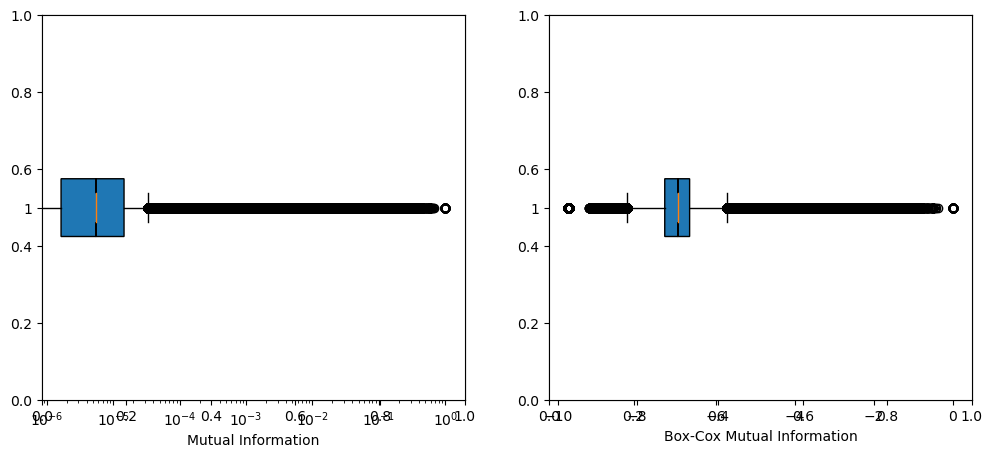

CPU times: user 1min 35s, sys: 9.16 s, total: 1min 44s
Wall time: 1min 44s


In [ ]:
#| eval: false
%%time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.boxplot(mut_infos, vert=0, notch=True, patch_artist=True)
ax1.set_xscale('log')
ax1.set_xlabel('Mutual Information')

ax2.boxplot(bcx_mut_infos, vert=0, notch=True, patch_artist=True)
# ax2.set_xscale('symlog')
ax2.set_xlabel('Box-Cox Mutual Information')

plt.show()

Histograms and kde using matplotlib:

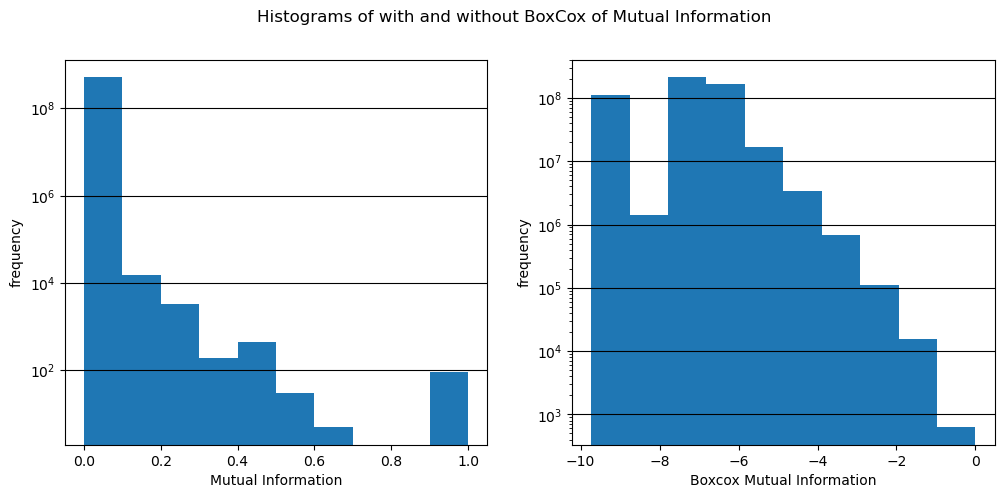

In [ ]:
#| eval: false
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# hist, bins, pathches = ax1.hist(df_l2r['mutual_info'])
hist, bins, pathches = ax1.hist(mut_infos)
ax1.set_xlabel('Mutual Information')
ax1.set_ylabel('frequency')
ax1.grid(axis='y', color='black')
ax1.set_yscale('log')

# ax2.hist(df_l2r['bcx_mutual_info'])
ax2.hist(bcx_mut_infos)
ax2.set_xlabel('Boxcox Mutual Information')
ax2.set_ylabel('frequency')
ax2.grid(axis='y', color='black')
ax2.set_yscale('log')

fig.suptitle('Histograms of with and without BoxCox of Mutual Information')
plt.show()

In [ ]:
#| eval:false
bdrs = [bins[i:i+2] for i in range(0, len(bins)-1)]
pd.DataFrame({'mut_infos bdrs': bdrs, 'counts': hist})

,mut_infos bdrs,counts
0,"[0.0, 0.09999963641166687]",511675599.0
1,"[0.09999963641166687, 0.19999927282333374]",14848.0
2,"[0.19999927282333374, 0.2999989092350006]",3323.0
3,"[0.2999989092350006, 0.3999985456466675]",191.0
4,"[0.3999985456466675, 0.49999818205833435]",454.0
5,"[0.49999818205833435, 0.5999978184700012]",30.0
6,"[0.5999978184700012, 0.6999974250793457]",5.0
7,"[0.6999974250793457, 0.799997091293335]",0.0
8,"[0.799997091293335, 0.8999967575073242]",0.0
9,"[0.8999967575073242, 0.9999963641166687]",94.0


In [ ]:
# from scipy.stats import gaussian_kde
# density = gaussian_kde(df_l2r['mutual_info'])
# xs = np.linspace(0, 1, 200)
# density.covariance_factor = lambda : .25
# density._compute_covariance()
# plt.plot(xs, density(xs))
# plt.show()

We can now build the `Dataloaders` object from this dataframe `df_collab`, by defaultit takes the first column as the user (in our case the token) and the second column as the item (in our case the label), and the third column as the ratings (in our case the frequency):

## Build `L2RDataloader` 

In this section we'll build `L2RDataLoader` for [Learning to Rank (L2R)](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/MSR-TR-2010-82.pdf)

In [ ]:
#| eval: false
df_l2r = pd.read_feather(source/'mimic3-9k_tok_lbl.ft')

In [ ]:
df_l2r = df_l2r.drop(['mutual_info', 'bcx_mutual_info'], axis=1)
df_l2r.token.nunique(), df_l2r.label.nunique()
df_l2r.head(3)

,token,label,rank
0,0,0,866.0
1,0,1,1022.0
2,0,2,1156.0


**`df_tiny`**: If we need a smaller dataset for quick iterations

Note: For technical reasons behind building a `L2RDataloader` the number of tokens should be $x (mod 64) \equiv 8$.

In [ ]:
num_toks, num_lbs = 8 + 5*64, 104

In [ ]:
# might have to repeat this a few times until the cell asserst true
np.random.seed(101)
rnd_toks = np.random.randint(0, len(df_l2r.token.unique()), size=(num_toks,) )
np.random.seed(101)
rnd_lbs = np.random.randint(0, len(df_l2r.label.unique()), size=(num_lbs,) )
mask = df_l2r.token.isin(rnd_toks) & df_l2r.label.isin(rnd_lbs)
df_tiny = df_l2r[mask].reset_index(drop=True)
test_eq(df_tiny.token.nunique(), num_toks) 
test_eq(df_tiny.label.nunique(), num_lbs) 
# df_tiny.apply(lambda x: x.nunique())

In [ ]:
df_tiny.head()

,token,label,rank
0,22,49,1877.0
1,22,239,21308.0
2,22,394,39854.0
3,22,436,8618.0
4,22,561,1646.0


Let's just delete the `df_l2r` to free up RAM:

In [ ]:
# df_l2r = pd.DataFrame()
# lst = [df_l2r]
# del lst
# del df_l2r
# import gc; gc.collect()

**Only for `df_tiny`**:

Due to random sampling the rankings are not uniform i.e., not from 0 to `num_toks`. A litte preprocessing to make sure that we have uniform rankings for all labels. 

In [ ]:
grouped = df_tiny.groupby('label', group_keys=False)

In [ ]:
def sort_rerank(df, column='rank'):
    df = df.sort_values(by=column)
    df['rank'] = range(len(df))
    return df

In [ ]:
df_tiny = grouped.apply(sort_rerank)
dict_grouped = dict(list(df_tiny.groupby('label')))
# checking a random label has ranks 0 thru `num_toks`
a_lbl = random.choice(list(dict_grouped.keys()))
test_eq(range(num_toks), dict_grouped[a_lbl]['rank'].values)

In [ ]:
dict_grouped[a_lbl].head()

,token,label,rank
11896,21311,3182,0
25520,43543,3182,1
19488,36047,3182,2
10960,18491,3182,3
6592,11782,3182,4


Using Pandas `groupby` to add quantized *relevance scores* to each token-label pair based on the corresponding ranks:

In [ ]:
grouped = df_tiny.groupby('label')

In [ ]:
# dict_grouped = dict(list(grouped))
# _tmp = dict_grouped[16].copy()
# _tmp.head()

In [ ]:
def cut(df, qnts, column='rank'):
    num = df.to_numpy()
    bins = np.quantile(num[:, -1], qnts)
    num[:, -1] = len(bins) - np.digitize(num[:, -1], bins)
    # bins = np.quantile(df['rank'], qnts)
    # df[column] = len(bins) - np.digitize(df['rank'], bins)
    # df[column] = pd.qcut(df[column], qnts, labels=labels)
    return num

In [ ]:
%%timeit -n 50 -r 15
qnts = np.concatenate([array([0]), np.geomspace(1e-2, 1, 10)])
scored = grouped.apply(cut, qnts) 

11.7 ms ± 154 µs per loop (mean ± std. dev. of 15 runs, 50 loops each)


Pandas `groupby` was just to ellucidate how we do the scoring. It ain't all that good when dealing with big datasets. So in reality we are going to use tensorized implemnetation. Follow along:

In [ ]:
pdl = PreLoadTrans(df_tiny, device=torch.device('cpu'))

If interested please read sourcecode of [`PreLoadTrans.quantized_score`](10_l2r.data.load):

In [ ]:
# %%timeit -n 50 -r 15
%time
scored_toks = pdl.quantized_score()

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


/home/deb/xcube/xcube/l2r/data/load.py:56: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/aten/src/ATen/native/BucketizationUtils.h:33.)
  relv_scores = bins.shape[0] - torch.searchsorted(bins.T, data[:, :, -1], right=False) # shape (8922, 57352)


In [ ]:
test_eqs(scored_toks.shape, 
         (df_tiny.label.nunique(), df_tiny.token.nunique(), 4), 
         (pdl.num_lbs, pdl.num_toks, 4))

Save if you want to! BTW `untar_xxx` has got the one for the full dataset:

In [ ]:
L(source.glob("**/*scored*.pth"))

(#1) [Path('/home/deb/.xcube/data/mimic3_l2r/scored_tokens.pth')]

Create training and validation split:

**Remember**: In `scored_toks` dim 0: labels, dim 1: 4 tuple (token, label, rank, score). Below is an example:

In [ ]:
tok, lbl, rank, score = L(scored_toks[97, 32], use_list=True).map(Tensor.item)
ic(tok, lbl, rank, score);

ic| tok: 41514.0, lbl: 8124.0, rank: 234.0, score: 4.0


In [ ]:
df_tiny[(df_tiny.token == tok)  & (df_tiny.label == lbl)]

,token,label,rank
23393,41514,8124,234


**Remember:** For each label the tokens are ranked 0 through `num_toks`

In [ ]:
ranks = scored_toks[:, :, 2].unique(dim=1).sort(-1).values
ranks_shouldbe = torch.arange(scored_toks.shape[1], dtype=torch.float).expand(scored_toks.shape[0], -1)
test_eq(ranks, ranks_shouldbe)

**Remember:** For each label `quantized_score` scores the tokens on a log scale based on their ranks. The score scale is 1-101: 101 being the highest score (assigned to most relevant  token), and 1 is the lowest score (assigned to least relevant tokens).

In [ ]:
scores = scored_toks[:, :, -1].unique(dim=1).sort(-1).values
scores[0]

tensor([  1.,   1.,   1.,   1.,   2.,   2.,   2.,   2.,   2.,   2.,   3.,   3.,
          3.,   3.,   4.,   4.,   4.,   4.,   4.,   4.,   5.,   5.,   5.,   6.,
          6.,   6.,   6.,   6.,   6.,   7.,   7.,   7.,   7.,   7.,   8.,   8.,
          8.,   8.,   8.,   8.,   8.,   8.,   9.,   9.,   9.,   9.,   9.,   9.,
         10.,  10.,  10.,  10.,  11.,  11.,  11.,  11.,  11.,  11.,  12.,  12.,
         12.,  12.,  12.,  13.,  13.,  13.,  13.,  13.,  13.,  14.,  14.,  14.,
         14.,  15.,  15.,  15.,  16.,  16.,  16.,  17.,  17.,  17.,  17.,  17.,
         18.,  18.,  18.,  19.,  19.,  19.,  19.,  20.,  20.,  20.,  20.,  21.,
         21.,  21.,  21.,  22.,  22.,  22.,  22.,  23.,  23.,  23.,  23.,  24.,
         24.,  24.,  25.,  25.,  25.,  26.,  26.,  27.,  27.,  27.,  28.,  28.,
         29.,  29.,  30.,  30.,  31.,  31.,  32.,  32.,  33.,  34.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  42.,  43.,  45.,  48.,  51.,  55.,  63.,
        101.])

In [ ]:
%%time
scored_toks, binned_toks, probs, is_valid, bin_size, bin_bds = pdl.train_val_split()

CPU times: user 12.4 ms, sys: 0 ns, total: 12.4 ms
Wall time: 2.31 ms


In [ ]:
%%time
val_sl = pdl.pad_split()
test_eq(is_valid.sum(dim=-1).unique().item(), val_sl)
print(f"{val_sl=}")

val_sl=16
CPU times: user 93.5 ms, sys: 3.97 ms, total: 97.5 ms
Wall time: 12.4 ms


Taking a look at the train/valid split for some labels (just to make sure we ticked all boxes!):

In [ ]:
df1 = pd.DataFrame(scored_toks[89], columns=['token', 'label', 'rank', 'score']).sort_values(by='score', ascending=False)
df1

,token,label,rank,score
226,28488.0,6820.0,0.0,101.0
225,2274.0,6820.0,1.0,63.0
224,50503.0,6820.0,2.0,55.0
223,56935.0,6820.0,3.0,51.0
222,20945.0,6820.0,4.0,48.0
...,...,...,...,...
112,57124.0,6820.0,320.0,1.0
114,9772.0,6820.0,318.0,1.0
115,907.0,6820.0,317.0,1.0
116,4924.0,6820.0,316.0,1.0


In [ ]:
name = partial(namestr, namespace=globals())
row_vals = apply(torch.Tensor.size, (scored_toks, binned_toks, probs, is_valid, bin_size, bin_bds))
pd.DataFrame(index = list(itertools.chain.from_iterable(apply(name, [scored_toks, binned_toks, probs, is_valid, bin_size, bin_bds]))), columns=['shape'], data={'shape': row_vals})

,shape
scored_toks,"(104, 328, 4)"
binned_toks,"(104, 328)"
probs,"(104, 328)"
is_valid,"(104, 328)"
bin_size,"(11,)"
bin_bds,"(8, 2)"


Lowest numbered bin contains irrelevant tokens for a label, and the highest numbered bin contains most relevant tokens:

In [ ]:
df2 = pd.DataFrame({'bin #': range(len(bin_size)), 
                    #'bin_bds': list(bin_bds.numpy()), 
                    'bin_size': bin_size})
df2

,bin #,bin_size
0,0,30
1,1,180
2,2,75
3,3,27
4,4,10
5,5,4
6,6,1
7,7,0
8,8,0
9,9,0


In [ ]:
df_toks = pd.read_feather(source/'mimic3-9k_tok.ft')
df_lbs = pd.read_feather(source/'mimic3-9k_lbl.ft')

a_lbl = np.random.choice(pdl.num_lbs)
df_lbs.iloc[[a_lbl]]
# df_lbs.loc[[a_lbl]]

,lbl,lbl_val
52,52,018.95


In [ ]:
df3 = pd.DataFrame({'token': scored_toks[a_lbl, :, 0] ,'score': scored_toks[a_lbl, :, -1], 'probs': probs[a_lbl], 
                    'binned_toks': binned_toks[a_lbl], 
                    #'bds': list(bin_bds[binned_toks[a_lbl]].numpy()), 
                    'size': bin_size[binned_toks[a_lbl]], 
                    'is_valid': is_valid[a_lbl]})
df3 = df_toks.merge(df3, on='token')
df3.sort_values(by='score', ascending=False).head(20)

,token,tok_val,score,probs,binned_toks,size,is_valid
30,4924,distance,101.0,0.333333,10,1,0.0
25,4056,defined,63.0,0.333333,6,1,0.0
10,2100,wnl,55.0,0.166667,5,4,1.0
2,436,change,51.0,0.166667,5,4,0.0
3,591,motion,48.0,0.166667,5,4,0.0
5,1327,residual,45.0,0.166667,5,4,0.0
0,22,patient,43.0,0.066667,4,10,0.0
7,1788,thursday,42.0,0.066667,4,10,0.0
6,1699,clopidogrel,40.0,0.066667,4,10,0.0
9,2021,saturations,39.0,0.066667,4,10,0.0


In [ ]:
test_eqs(is_valid[a_lbl].sum(), df3['is_valid'].sum(), pdl.val_sl)

In [ ]:
df3[df3['is_valid'] == 1].sort_values(by='score', ascending=False)#.groupby('binned_toks').size()

,token,tok_val,score,probs,binned_toks,size,is_valid
10,2100,wnl,55.0,0.166667,5,4,1.0
19,3621,cortisol,30.0,0.024691,3,27,1.0
154,29405,angigraphy,22.0,0.008889,2,75,1.0
179,34435,x21,19.0,0.008889,2,75,1.0
221,41317,boric,14.0,0.008889,2,75,1.0
50,9139,ug,11.0,0.003704,1,180,1.0
139,26556,manangement,7.0,0.003704,1,180,1.0
149,28488,closures,7.0,0.003704,1,180,1.0
175,33793,bibas,6.0,0.003704,1,180,1.0
183,35391,bender,5.0,0.003704,1,180,1.0


In [ ]:
top_lens = pdl.count_topbins()
test_eq(top_lens.shape, [pdl.num_lbs])
print(f"For {torch.where(top_lens >= 1)[0].numel()} labels out of total {pdl.num_lbs}, in the validation set we have at least one top 2 bin")

For 71 labels out of total 104, in the validation set we have at least one top 2 bin


Prepare the train/val dataset:

In [ ]:
trn_dset, val_dset = pdl.datasets()

In [ ]:
test_eq(val_dset.shape, (scored_toks.shape[0], val_sl, scored_toks.shape[2]))
test_eq(trn_dset.shape, scored_toks.shape) 
ic(trn_dset.shape, val_dset.shape);

ic| trn_dset.shape: torch.Size([104, 328, 4])
    val_dset.shape: torch.Size([104, 16, 4])


Again, `untar_xxx` has got the trn/val split for the full dataset:

In [ ]:
L(source.glob("**/*split*.pkl"))

(#1) [Path('/home/deb/.xcube/data/mimic3_l2r/trn_val_split.pkl')]

In [ ]:
trn_dset, val_dset = torch.load(source/'trn_val_split.pkl')
ic(trn_dset.shape, val_dset.shape);

ic| trn_dset.shape: torch.Size([8922, 57352, 4])
    val_dset.shape: torch.Size([8922, 32, 4])


Now we are ready to create the train/valid `DataLoaders`:

**Implementation note:** We have written the training dataloader which we call `L2RDataLoader`. It ofcourse inherits from fastai's incredibly hackable [`DataLoader`](https://docs.fast.ai/data.load.html#dataloader) class. In a little more technical terms, another way to say this is that `L2RDataLoader` provides different implementation of the callbacks `before_iter` and `create_batches`. However for the validation dataloader we directly use fastai's `DataLoader`. Lastly, we store the training and validation dataloder objects using fastai's [`DataLoaders`](https://docs.fast.ai/data.core.html#dataloaders) class.

In [ ]:
bs_full = 32
bs_tiny = 8
sl = 64
lbs_chunks_full = 4
lbs_chunks_tiny = 32
trn_dl = L2RDataLoader(dataset=trn_dset, sl=sl, bs=bs_full, lbs_chunks=lbs_chunks_full, shuffle=False, after_batch=partial(to_device, device=default_device(use=True)), num_workers=0)

Don't forget to check the length

In [ ]:
len(trn_dl)

113

In [ ]:
ic(trn_dl.num_workers, trn_dl.fake_l.num_workers);

ic| trn_dl.num_workers: 1, trn_dl.fake_l.num_workers: 0


In [ ]:
xb = trn_dl.one_batch()
ic(xb.shape, xb.device);

ic| xb.shape: torch.Size([32, 2231, 64, 4])
    xb.device: device(type='cuda', index=0)


In [ ]:
%%time
for xb in progress_bar(trn_dl):
    time.sleep(0.01)

CPU times: user 1min 6s, sys: 10.3 s, total: 1min 16s
Wall time: 9.76 s


In [ ]:
from fastai.data.load import DataLoader
from fastai.data.core import DataLoaders

In [ ]:
val_dset = val_dset.unsqueeze(0)
val_dl = DataLoader(val_dset, bs=1, shuffle=False, after_batch=partial(to_device, device=default_device()), num_workers=0)
ic(val_dl.num_workers, val_dl.fake_l.num_workers);

ic| val_dl.num_workers: 1, val_dl.fake_l.num_workers: 0


In [ ]:
xb = val_dl.one_batch()
ic(xb.shape, xb.device);

ic| xb.shape: torch.Size([1, 8922, 32, 4])
    xb.device: device(type='cuda', index=0)


In [ ]:
%%time
for xb in progress_bar(val_dl):
    time.sleep(0.01)

CPU times: user 157 ms, sys: 1.14 ms, total: 158 ms
Wall time: 24.4 ms


In [ ]:
dls = DataLoaders(trn_dl, val_dl)

## Training

...yes, finally!

#### **Keeping records:**

In [ ]:
m = ['lin', 'nn']
algos = ['ranknet', 'lambda-rank']
idx = pd.Index(['mimic-tiny', 'mimic-full'], name='dataset')
cols = pd.MultiIndex.from_product([m, algos], names = ['model', 'algo'])

df = pd.DataFrame(columns=cols, index=idx)
df[:] = 'TBD'

df.loc['mimic-tiny']['nn']['ranknet'] = "{'grad_func': functools.partial(<function rank_loss3 at 0x7f6f87e800d0>, gain_fn='exp', k=6), 'opt_func': functools.partial(<function RMSProp at 0x7f6f87e31870>, mom=0.9, wd=0.2), 'opt': None, 'lr': 0.001, 'loss_func': <function loss_fn2 at 0x7f6f7cdb1990>, 'num_factors': 200, 'n_act': 100, 'num_lbs': 105, 'num_toks': 329, 'seed': 877979, 'epochs': 15, 'best': 75.66}"
df.loc['mimic-tiny']['lin']['ranknet'] = "{'grad_func': functools.partial(<function rank_loss3 at 0x7f6f87e800d0>, gain_fn='exp', k=6), 'opt_func': functools.partial(<function SGD at 0x7f6f87e31750>, mom=0.9), 'opt': None, 'lr': 0.0001, 'loss_func': <function loss_fn2 at 0x7f6f73f748b0>, 'num_factors': 200, 'num_lbs': 105, 'num_toks': 329, 'seed': 877979, 'epochs': 15, 'best': 75}"
df.loc['mimic-tiny']['nn']['lambda-rank'] = "{'grad_func': functools.partial(<function rank_loss3 at 0x7f4c7dd42c20>, gain_fn='exp', k=15, lambrank=True), 'opt_func': functools.partial(<function RMSProp at 0x7f4c7dd04160>, mom=0.9, wd=0.0), 'opt': <fastai.optimizer.Optimizer object at 0x7f4c5e046a10>, 'lr': 0.001, 'loss_func': <function loss_fn2 at 0x7f4c74b9add0>, 'num_factors': 200, 'n_act': 100, 'num_lbs': 105, 'num_toks': 329, 'seed': 1, 'epochs': 15, 'best': 33.08}"
df.loc['mimic-tiny']['lin']['lambda-rank'] = "{'grad_func': functools.partial(<function rank_loss3 at 0x7f4c7dd42c20>, gain_fn='exp', k=15, lambrank=True), 'opt_func': functools.partial(<function RMSProp at 0x7f4c7dd04160>, mom=0.9, wd=0.0), 'opt': <fastai.optimizer.Optimizer object at 0x7f4c5c1da410>, 'lr': 0.007, 'loss_func': <function loss_fn2 at 0x7f4c74b9add0>, 'num_factors': 200, 'n_act': None, 'num_lbs': 105, 'num_toks': 329, 'seed': 1, 'epochs': 15, 'best': 52.21}"

df.loc['mimic-full']['nn']['ranknet'] = 'TBD'
df.loc['mimic-full']['lin']['ranknet'] = {'lr': 1e-5, 'opt': 'partial(SGD, mom=0.9, wd=0.0)', 'best': 63.73, 'epochs': 3, 'seed': 1, 'gain': 'cubic', 'factors': 100}
df.loc['mimic-full']['nn']['lambda-rank'] = 'TBD'
df.loc['mimic-full']['lin']['lambda-rank'] = {'lr': [7e-4, 7e-4, 7e-4], 'opt': 'partial(RMSProp, mom=0.9, wd=0.0)', 'best': 12.85, 'epochs': [4, 2, 4, 4], 'seed': 1, 'gain': 'exp', 'factors': 200}

In [ ]:
df

model                                                                                                                                                                                                                                                                                                                                                         lin  \
algo                                                                                                                                                                                                                                                                                                                                                      ranknet   
dataset                                                                                                                                                                                                                                                                                                                                                             
mimic-tiny  {'grad_func': functools.partial(<function rank_loss3>, gain_fn='exp', k=6), 'opt_func': functools.partial(<function SGD>, mom=0.9), 'opt': None, 'lr': 0.0001, 'loss_func': <function loss_fn2>, 'num_factors': 200, 'num_lbs': 105, 'num_toks': 329, 'seed': 877979, 'epochs': 15, 'best': 75}   
mimic-full                                                                                                                                                                                                                          {'lr': 1e-05, 'opt': 'partial(SGD, mom=0.9, wd=0.0)', 'best': 63.73, 'epochs': 3, 'seed': 1, 'gain': 'cubic', 'factors': 100}   

model                                                                                                                                                                                                                                                                                                                                                                                                                                                       \
algo                                                                                                                                                                                                                                                                                                                                                                                                                                           lambda-rank   
dataset                                                                                                                                                                                                                                                                                                                                                                                                                                                      
mimic-tiny  {'grad_func': functools.partial(<function rank_loss3>, gain_fn='exp', k=15, lambrank=True), 'opt_func': functools.partial(<function RMSProp>, mom=0.9, wd=0.0), 'opt': <fastai.optimizer.Optimizer object>, 'lr': 0.007, 'loss_func': <function loss_fn2>, 'num_factors': 200, 'n_act': None, 'num_lbs': 105, 'num_toks': 329, 'seed': 1, 'epochs': 15, 'best': 52.21}   
mimic-full                                                                                                                                                                                                                                                                                   {'lr': [0.0007, 0.0007, 0.0007], 'opt': 'partial(RMSProp, mom=0.9, wd=0.0)', 'best': 12.85, 'epochs': [4, 2, 4, 4], 'seed': 1, 'gain': 'exp', 'factors': 200}   

model                                                                                                        

#### **Get the `DataLoaders`:**

In [ ]:
#| eval: false
tmp = Path.cwd()/'tmp'
tmp.mkdir(exist_ok=True)
list_files(str(tmp))

tmp/
    lambdarank-full.pth
    dls_full.pkl
    dls_tiny.pkl
    lambdarank-tiny.pth
    dls_clas.pkl
    ranknet-tiny.pth
    .ipynb_checkpoints/


In [ ]:
set_seed(198989, True)

In [ ]:
#| eval: false
# torch.save(dls, tmp/'dls_full.pkl', pickle_protocol=4)
%time dls = torch.load(tmp/'dls_tiny.pkl')#, map_location=default_device())

CPU times: user 1.46 ms, sys: 28 µs, total: 1.49 ms
Wall time: 1.36 ms


#### **Make the Model:**

Based on the dataset:

In [ ]:
Datasizes = namedtuple("Datasizes", ('num_lbs', 'num_toks', 'num_factors'))
sizes = Datasizes(*dls.dataset.shape[:-1], 200) # or pdl.num_lbs, pdl.num_toks, 200
sizes

Datasizes(num_lbs=104, num_toks=328, num_factors=200)

In [ ]:
# model = L2R_DotProductBias(num_lbs, num_toks, num_factors, y_range=None).to(default_device())
# model = L2R_DotProductBias(*sizes,y_range=None).to(default_device())
model = L2R_NN(*sizes, n_act=100, dp=0.2, y_range=None).to(default_device())

**Create the `Learner` and train:**

In [ ]:
from fastai.callback.schedule import *

In [ ]:
cbs = [TrainEval(), TrackResults(train_metrics=True, beta=0.98), ProgressBarCallback(), Monitor(), SaveCallBack('lambdarank-tiny', monitor='ndcg_at_6')]
# cbs = [TrainEval(), TrackResults(train_metrics=True, beta=0.5), ProgressBarCallback(), Monitor(), 
#        SaveCallBack('ranknet-tiny', monitor='acc'),
#       ]

In [ ]:
from fastai.optimizer import *

In [ ]:
grad_fn = partial(rank_loss3, gain_fn='exp', k=15)
# learner = get_learner(model, dls, lr=1e-5, cbs=cbs) # lin # ranknet # full
# learner = get_learner(model, dls, grad_fn=grad_fn, opt_func=partial(RMSProp, mom=0.9, wd=0.0), lambrank=True, lr=7e-3, cbs=cbs) # lin # lambdarank # full
# learner = get_learner(model, dls, lr=1e-2, grad_fn=grad_fn, opt_func=partial(RMSProp, mom=0.9, wd=0.2), cbs=cbs) # nn ranknet tiny
learner = get_learner(model, dls, lr=1e-3, grad_fn=grad_fn, lambrank=True, opt_func=partial(RMSProp, mom=0.9, wd=0.0), cbs=cbs)  # nn lambdarank tiny
# learner = get_learner(model, dls, lr=1e-2, grad_fn=grad_fn, lambrank=True, opt_func=partial(Adam, mom=0.9, wd=0.1), cbs=cbs)  # nn lambdarank full
# learner = get_learner(model, dls, grad_fn=grad_fn, lr=1e-4, cbs=cbs) #lin #ranknet #tiny
# learner = get_learner(model, dls, grad_fn=grad_fn, opt_func=partial(RMSProp, mom=0.9, wd=0.0), lambrank=True, lr=7e-3, cbs=cbs) #lin #lambdarank #tiny

In [ ]:
#| eval:false
learner.path = tmp

Let's record some useful hyperparameters in a record dict which we can store in the dataframe in the record keeping section:

In [ ]:
learner_attrs = ['grad_func', 'opt_func', 'opt', 'lr', 'loss_func']
model_attrs = ['num_factors', 'n_act', 'num_lbs', 'num_toks']
record = dict(zip(learner_attrs + model_attrs, getattrs(learner, *learner_attrs) + getattrs(learner.model, *model_attrs)))
record['seed'] = torch.initial_seed()
record['epochs'] = 15
record['best'] = 52.21
str(record)

"{'grad_func': functools.partial(<function rank_loss3>, gain_fn='exp', k=15, lambrank=True), 'opt_func': functools.partial(<function RMSProp>, mom=0.9, wd=0.0), 'opt': None, 'lr': 0.001, 'loss_func': <function loss_fn2>, 'num_factors': 200, 'n_act': 100, 'num_lbs': 105, 'num_toks': 329, 'seed': 1, 'epochs': 15, 'best': 52.21}"

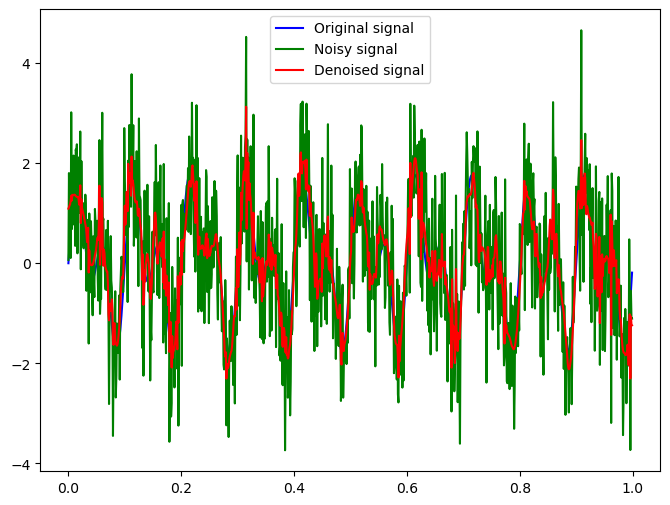

In [ ]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

# Generate a noisy signal
t = np.linspace(0, 1, 1000, endpoint=False)
signal = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*20*t)
noise = np.random.normal(0, 1, len(signal))
noisy_signal = signal + noise

# Perform wavelet transform
wavelet = 'db4'
level = 4
coeffs = pywt.wavedec(noisy_signal, wavelet, level=level)

# Remove high-frequency noise
threshold = 0.5
for i in range(1, len(coeffs)):
    coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))

# Reconstruct the denoised signal
denoised_signal = pywt.waverec(coeffs, wavelet)

# Plot the results
plt.figure(figsize=(8,6))
plt.plot(t, signal, 'b', label='Original signal')
plt.plot(t, noisy_signal, 'g', label='Noisy signal')
plt.plot(t, denoised_signal, 'r', label='Denoised signal')
plt.legend()
plt.show()


Finding learning rate:

Smoothing ndcg_at_6


0 True 0.6918 0.4514 0.2779 0.4387
0 False NA NA NA NA
1 True 0.6882 0.4927 0.3416 0.448
1 False NA NA NA NA
2 True 0.6855 0.521 0.3761 0.4585
2 False NA NA NA NA
3 True 0.6884 0.4969 0.3428 0.4648
3 False NA NA NA NA
4 True 0.68 0.5456 0.4128 0.4822
4 False NA NA NA NA
5 True 0.7069 0.5518 0.4184 0.4878
5 False NA NA NA NA
6 True 0.6977 0.5492 0.4235 0.4972
6 False NA NA NA NA
7 True 0.6827 0.5768 0.4595 0.5168
7 False NA NA NA NA
8 True 0.7442 0.5721 0.4461 0.5121
8 False NA NA NA NA
9 True 0.7287 0.5763 0.4615 0.5135
9 False NA NA NA NA
10 True 0.8406 0.553 0.4145 0.5127
10 False NA NA NA NA
11 True 0.8225 0.5387 0.3936 0.5149
11 False NA NA NA NA
12 True 0.7606 0.5309 0.3906 0.4981
12 False NA NA NA NA
13 True 0.8999 0.5101 0.3586 0.4978
13 False NA NA NA NA
14 True 1.0496 0.5201 0.3723 0.5108
14 False NA NA NA NA
15 True 1.9781 0.5148 0.371 0.4965
15 False NA NA NA NA
16 True 3.7797 0.4951 0.3225 0.4573
16 False NA NA NA NA
17 True 1.9204 0.4401 0.2378 0.3357
17 False NA NA NA NA


SuggestedLRs(valley=0.028054336085915565, slide=0.061944108456373215, steep=0.014723124913871288)

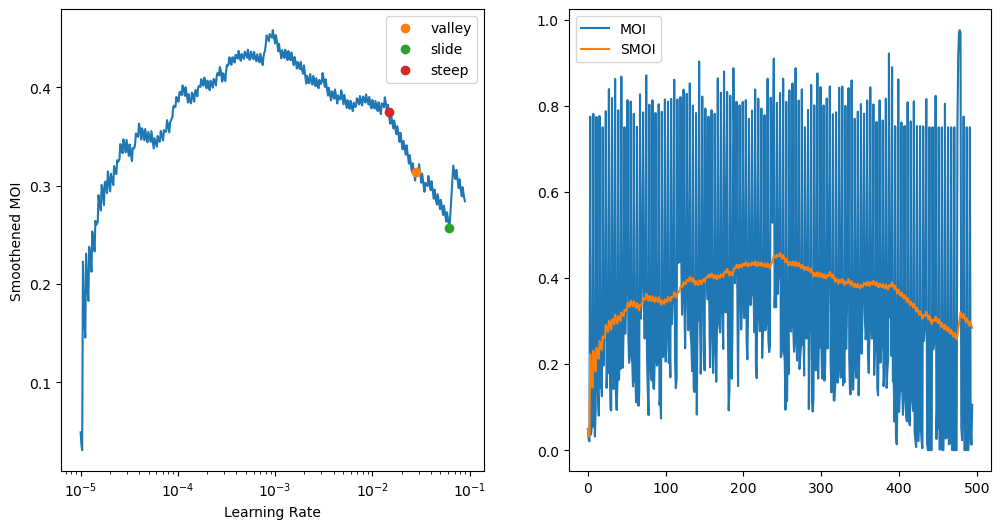

In [ ]:
learner.xrl_find(num_it=500, suggest_funcs=(valley, slide, steep))

In [ ]:
learner.fit_one_cycle(1, lr_max=0.014723124913871288)
learner.fit_one_cycle(15, lr_max=0.014723124913871288)

0 True 0.8708 0.4975 0.3466 0.4554
0 False 0.649 0.5923 0.5247 0.6347
Better model found at epoch 0 with ndcg_at_6 value: 0.5247.


0 True 0.755 0.5573 0.429 0.4887
0 False 0.6763 0.4598 0.3367 0.6313
1 True 0.938 0.5708 0.444 0.5065
1 False 0.9044 0.5296 0.4754 0.6751
2 True 1.0764 0.6086 0.484 0.5133
2 False 0.8 0.6495 0.5932 0.6855
Better model found at epoch 2 with ndcg_at_6 value: 0.5932.
3 True 1.1127 0.5953 0.4894 0.5114
3 False 0.8307 0.6621 0.6347 0.6886
Better model found at epoch 3 with ndcg_at_6 value: 0.6347.
4 True 1.2074 0.5768 0.4544 0.5137
4 False 0.9286 0.6646 0.6353 0.689
Better model found at epoch 4 with ndcg_at_6 value: 0.6353.
5 True 1.3879 0.5985 0.489 0.5096
5 False 0.8333 0.56 0.5112 0.665
6 True 1.2363 0.5782 0.4617 0.5102
6 False 0.9348 0.6096 0.575 0.6903
7 True 1.4549 0.6073 0.4919 0.5162
7 False 0.9876 0.656 0.6382 0.6927
Better model found at epoch 7 with ndcg_at_6 value: 0.6382.
8 True 1.5196 0.6002 0.4849 0.5155
8 False 0.6668 0.633 0.6162 0.6939
9 True 1.3399 0.584 0.4532 0.513
9 False 0.6113 0.6651 0.6276 0.6877
10 True 0.9574 0.5857 0.4633 0.5257
10 False 0.7048 0.7275 0.7107 0.

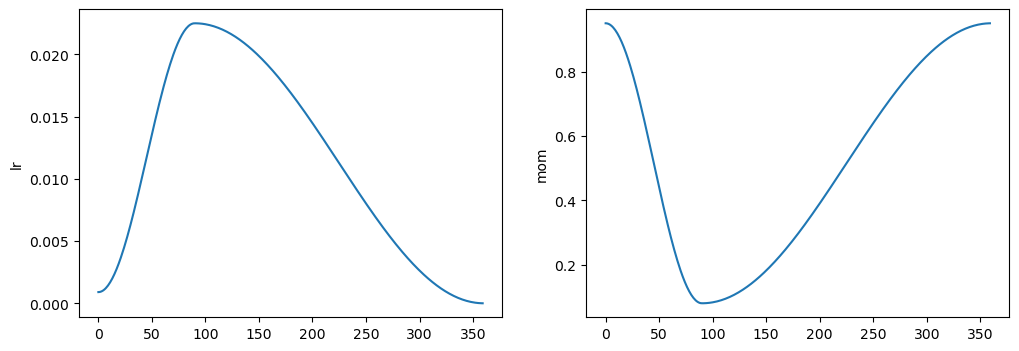

In [ ]:
learner.track_results.plot_sched()

In [ ]:
# len(learner.cbs[1].grads_full['token_factors.weight'])
# learner.cbs
# learner.track_results
# learner.opt.hypers[-1]

In [ ]:
learner = learner.load('lambdarank-tiny', device=default_device())

In [ ]:
learner.validate()

14 False 0.8392 0.729 0.7116 0.7243


In [ ]:
learner.cbs[-1].best = 0.8067

#### Plots

**Plotting losses and metrics:**

In [ ]:
#| eval: false
fig, axes = plt.subplots(2, 2, figsize=(15,8))
loss = L(loss_logger).map(torch.Tensor.item)
val_loss = L(metric_logger).itemgot(0)
val_acc = L(metric_logger).itemgot(-1)
val_ndcg = L(metric_logger).itemgot(2)

# axes[0,0].scatter(range(len(loss)), loss)
axes[0,0].plot(range(len(loss)), loss)
axes[0,0].set_xlabel('batches*epochs')
axes[0,0].set_ylabel('train loss')

axes[0,1].plot(val_loss)
axes[0,1].set_xlabel('epochs')
axes[0,1].set_ylabel('val loss')

axes[1, 0].plot(val_acc)
axes[1,0].set_xlabel('epochs')
axes[1,0].set_ylabel('val accuracy')

axes[1,1].plot(val_ndcg)
axes[1,1].set_xlabel('epochs')
axes[1,1].set_ylabel('val ndcg@6 (candidate 16)')

plt.show()

**Plotting Statistics of the Model Parameters**

In [ ]:
#| eval: false
fig, axes = plt.subplots(2,2, figsize=(15,8), sharex=True)
for (k,v), ax in zip(grad_logger.items(), axes.flatten()):
    mean_grads = L(v).map(compose(torch.Tensor.square, torch.Tensor.mean, torch.Tensor.sqrt, torch.Tensor.item))
    # sparsity = L(v).map(sparsity)
    ax.plot(mean_grads, color='r', label='mean')
    ax.set_ylabel(k)
    # ax_a = ax.twinx()
    # ax_a.plot(sparsity, color='b', label='sparsity')
    ax.legend(loc='best')
    # ax_a.legend(loc='best')
fig.suptitle('RMS of the Gradients of Model Parameters')
plt.show()

In [ ]:
def sparsity(t): 
    return 1 - (torch.count_nonzero(t)/t.numel()).item()

In [ ]:
#| eval: false
fig, axes = plt.subplots(2,2, figsize=(15,8), sharex=True)
for (k,v), ax in zip(grad_logger.items(), axes.flatten()):
    sp = L(v).map(sparsity)
    ax.scatter(range(len(sp)), sp, color='r', label='sparsity')
    ax.set_ylabel(k)
    # ax_a = ax.twinx()
    # ax_a.plot(sparsity, color='b', label='sparsity')
    ax.legend(loc='best')
    # ax_a.legend(loc='best')
fig.suptitle('Sparsity of the Model Parameters')
plt.show()

#### Analysis to find out what the L2R model is upto:

In [ ]:
dataset = to_device(learner.dls.train.dataset)

In [ ]:
%%time
_ndcg_at_k = ndcg_at_k(dataset, learner.model, k=15)

CPU times: user 44.3 ms, sys: 81 µs, total: 44.4 ms
Wall time: 46.2 ms


In [ ]:
ic(_ndcg_at_k.shape, _ndcg_at_k.min(), _ndcg_at_k.mean(), _ndcg_at_k.max(), _ndcg_at_k.median(), _ndcg_at_k.std());

ic| _ndcg_at_k.shape: torch.Size([1, 104])
    _ndcg_at_k.min(): tensor(4.4358e-21, device='cuda:0')
    _ndcg_at_k.mean(): tensor(0.2886, device='cuda:0')
    _ndcg_at_k.max(): tensor(1., device='cuda:0')
    _ndcg_at_k.median(): tensor(0.2789, device='cuda:0')
    _ndcg_at_k.std(): tensor(0.3050, device='cuda:0')


In [ ]:
%%time
acc = accuracy(dataset, learner.model)

CPU times: user 276 ms, sys: 0 ns, total: 276 ms
Wall time: 286 ms


In [ ]:
ic(acc.shape, acc.min(), acc.mean(), acc.max(), acc.median(), acc.std());

ic| acc.shape: torch.Size([1, 104])
    acc.min(): tensor(0.6281, device='cuda:0')
    acc.mean(): tensor(0.7566, device='cuda:0')
    acc.max(): tensor(0.7964, device='cuda:0')
    acc.median(): tensor(0.7626, device='cuda:0')
    acc.std(): tensor(0.0296, device='cuda:0')


Let's pick some random labels and see the rankings produced by the model:

In [ ]:
df_res, df_ndcg= learner.show_results(k=15)

In [ ]:
df_ndcg[df_ndcg.ndcg_at_k >= 0.4]

,labels,ndcg_at_k
2,3987,0.590105
38,2648,0.703947
40,1818,0.605277
48,86,0.483696
51,4023,0.509422
69,6538,0.608036


In [ ]:
df_ndcg.head(10)

,labels,ndcg_at_k
0,8526,4.967139e-16
1,7962,4.525589e-15
2,3987,5.901048e-01
3,6165,2.050589e-13
4,6168,3.538292e-10
5,2640,3.429065e-13
6,862,1.326269e-14
7,2750,2.974324e-14
8,7083,1.927360e-12
9,7382,3.322057e-13


In [ ]:
df_res

label     8526                                                  7962          \
key2       tok     lbl     rank score      preds model_rank      tok     lbl   
toks                                                                           
0      51577.0  8526.0  53191.0   1.0 -15.508224    56209.0  51577.0  7962.0   
1      52360.0  8526.0  27169.0   9.0 -14.260840    54364.0  52360.0  7962.0   
2      37101.0  8526.0  17341.0  13.0 -16.392403    56825.0  37101.0  7962.0   
3      37705.0  8526.0  17728.0  13.0  -8.327139    22974.0  37705.0  7962.0   
4      14257.0  8526.0  13884.0  16.0  -6.157008    13674.0  14257.0  7962.0   
...        ...     ...      ...   ...        ...        ...      ...     ...   
57347   4537.0  8526.0   4178.0  29.0   3.223763     1158.0   4537.0  7962.0   
57348   1622.0  8526.0   1667.0  39.0   6.897865      158.0   1622.0  7962.0   
57349  16373.0  8526.0  31881.0   7.0  -3.839412     8237.0  16373.0  7962.0   
57350  43863.0  8526.0  45724.0   3.0  -8.167515    22116.0  43863.0  7962.0   
57351  11619.0  8526.0     28.0  82.0  -3.012341     6961.0  11619.0  7962.0   

label                 ...     2383                                 2716  \
key2      rank score  ...     rank score      preds model_rank      tok   
toks                  ...                                                 
0      53190.0   1.0  ...  53188.0   1.0 -22.485952    45904.0  51577.0   
1      36923.0   5.0  ...  36922.0   5.0 -25.517452    54909.0  52360.0   
2      23691.0  10.0  ...  23689.0  10.0 -24.178604    51988.0  37101.0   
3      24078.0  10.0  ...  24076.0  10.0 -18.338791    24813.0  37705.0   
4       4592.0  28.0  ...   4600.0  28.0 -14.070593    11227.0  14257.0   
...        ...   ...  ...      ...   ...        ...        ...      ...   
57347  16782.0  14.0  ...  16778.0  14.0 -11.787257     7435.0   4537.0   
57348   1859.0  37.0  ...   1890.0  37.0  -0.648517      775.0   1622.0   
57349   5754.0  25.0  ...   5758.0  25.0 -15.933532    15824.0  16373.0   
57350  31399.0   7.0  ...  31402.0   7.0 -22.144417    44400.0  43863.0   
57351   5527.0  26.0  ...   5530.0  26.0 -11.885437     7559.0  11619.0   

label                                               
key2      lbl     rank score      preds model_rank  
toks                                                
0      2716.0  49385.0   2.0 -10.975304    48711.0  
1      2716.0  27070.0   9.0 -11.479145    50788.0  
2      2716.0  17456.0  13.0 -14.518932    56631.0  
3      2716.0  17843.0  13.0  -7.782197    31197.0  
4      2716.0  19106.0  12.0  -5.658982    20516.0  
...       ...      ...   ...        ...        ...  
57347  2716.0   3391.0  31.0   0.631838     3645.0  
57348  2716.0  32150.0   7.0   4.140281      518.0  
57349  2716.0  19008.0  12.0  -5.365396    19302.0  
57350  2716.0  40549.0   4.0  -6.623421    24890.0  
57351  2716.0  11709.0  18.0  -2.657717    10514.0  

[57352 rows x 600 columns]

In [ ]:
df_lbl = df_res.loc[:, 7962]
df_lbl

key2,tok,lbl,rank,score,preds,model_rank
toks,,,,,,
0,51577.0,7962.0,53190.0,1.0,-15.251304,12017.0
1,52360.0,7962.0,36923.0,5.0,-29.125181,57163.0
2,37101.0,7962.0,23691.0,10.0,-23.802099,49501.0
3,37705.0,7962.0,24078.0,10.0,-26.538891,55664.0
4,14257.0,7962.0,4592.0,28.0,-11.758639,5992.0
...,...,...,...,...,...,...
57347,4537.0,7962.0,16782.0,14.0,-11.796282,6039.0
57348,1622.0,7962.0,1859.0,37.0,-0.529713,415.0
57349,16373.0,7962.0,5754.0,25.0,-16.219601,14575.0


In [ ]:
df2 = df_lbl.sort_values(by='rank').head(15)
df2

key2,tok,lbl,rank,score,preds,model_rank
toks,,,,,,
15201,55164.0,7962.0,0.0,101.0,-15.159095,11785.0
9467,55263.0,7962.0,1.0,100.0,-13.725697,8897.0
46734,43276.0,7962.0,2.0,100.0,-10.007815,4163.0
32162,47129.0,7962.0,3.0,100.0,-14.688043,10748.0
52694,33991.0,7962.0,4.0,100.0,-11.626492,5833.0
28445,27076.0,7962.0,5.0,100.0,-8.625399,3121.0
32645,22679.0,7962.0,6.0,99.0,-13.767257,8968.0
31172,23346.0,7962.0,7.0,97.0,-12.819171,7446.0
42286,19429.0,7962.0,8.0,96.0,-12.749741,7343.0


In [ ]:
# idcg_at_k = pow(2, df2['score']) * (1 / np.log2(df2['rank']+2)  )
# idcg_at_k

# df3 = df_lbl.sort_values(by='model_rank').head(10)
# df3

# dcg_at_k = pow(2, df3['score'])  *(1/np.log2(df3['model_rank']+2))
# dcg_at_k

# dcg_at_k.sum()/idcg_at_k.sum()